## Week 6 Lab exercises

In this week we will show how to solve implicit ODEs with non linear terms, and investigate ill posed and ill conditioned problems.

In [15]:
# first we import the libraries we need
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The following lines makes the plots appear inline in the notebook
%matplotlib inline

### ACTIVITY 1: 

How can we solve the non linear Van der Pol oscillator equation using implicit methods?

Reminder: The Van der Pol oscillator with no source obeys the equation:

$\frac{d^2y}{dt^2} - 2a (1-y^2) \frac{dy}{dt} + y = 0$

which we can write in first order matrix form as

$\frac{d}{dt}\begin{bmatrix}
y \\
v \\
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
-1 & 2a(1-y^2)
\end{bmatrix} \begin{bmatrix}
y \\
v
\end{bmatrix}$

In the code below the equation is solved using the iterative scheme described in the lecture. Note that we still invert the matrix using the numpy functions. 

Amend the code for the following:

1. By adding some diagnostic quantities and/or print() statements, find out how many times on average we need to iterate through the guess for the new y value before it converges to the desired error threshold?

-> About 3 or 4

2. What has more effect on the accuracy of the solution compared to solve_ivp(), changing the threshold for the error during the non linear iterations, or increasing the number of timesteps (e.g. halving or doubling each value)?

-> The step size has more effect - even if we don't iterate more than once it works ok!

In [16]:
class VanDerPolOscillator:
    
    """Definition - a class to contain a Van Der Pol non linear
    damped oscillator.
    
       attributes: damping factor a, forcing function f_of_t, 
       lifetime of oscillations, plus private attributes for the solutions
       
       methods: to integrate the VDP equation, and produce plots of
       the solution and phase plots
    
    """
    
    # constructor function
    def __init__(self, a_damping_coeff=0.0, a_max_time = 1.0, 
                 a_N_time_steps=1000, a_epsilon = 1.0e-6):
        self.a = a_damping_coeff
        self.epsilon = a_epsilon
        self.max_time = a_max_time
        self.N_time_steps = a_N_time_steps
        self._delta_t = a_max_time / a_N_time_steps
        self._solution_y = np.zeros([2,a_N_time_steps+1])
        self._solution_t = np.linspace(0.0, a_max_time, a_N_time_steps+1)
        self._solution_solved = False
        
    def integrate_using_solve_ivp(self, y0) :
        solution = solve_ivp(self.calculate_VDP_dydt, [0,self.max_time],
                        y0, t_eval=self._solution_t)
        
        self._solution_y = solution.y
        self._solution_solved = True

    def integrate_using_backward_Euler(self, y0) :
        h = self._delta_t
        
        for itime, time in enumerate(self._solution_t) :
            if itime == 0 :
                self._solution_y[:,itime] = y0
            else :
                y_of_t_old   = self._solution_y[:,itime-1]
                y_of_t_old_matrix = np.matrix(y_of_t_old)
                
                # Remember we have to copy if we don't want to actually
                # amend the elements of y_of_t_old_matrix
                y_of_t_guess = np.copy(y_of_t_old_matrix)
                
                # Implement the iterative scheme described in the lecture
                error = 100.0
                error_threshold = self.epsilon
                iteration = 1
                while (error > error_threshold) :
                    
                    # Get the C matrix using the guess of y_new
                    C_matrix_t = self.get_C_matrix(y_of_t_guess)
                    I_plus_hC = np.eye(2) + h * C_matrix_t
                    I_plus_hC_inv = np.linalg.inv(I_plus_hC)
                    
                    # Get the new guess using the C matrix of the old one
                    y_of_t_new = I_plus_hC_inv * y_of_t_old_matrix.transpose()
                    
                    # If the new guess is the same as the old one we have converged
                    error = np.linalg.norm(y_of_t_guess - y_of_t_new)
                    y_of_t_guess = y_of_t_new
                    #print("error is ", error, " at iteration ", iteration)
                    iteration += 1
                    
                    # Check it is not getting worse!
                    assert error < 1000.0, 'Non linear iterations not converging!'
                    
                # Now (assuming it has converged) assign the 
                # value we found to to solution and continue the time iteration
                y_of_t_new_final = y_of_t_guess.transpose()   
                self._solution_y[:,itime] = y_of_t_new_final
                
        # Mark as solved
        self._solution_solved = True
        
    def calculate_VDP_dydt(self, t, y) :
        """Returns the gradient dy/dt for the Van Der Pol equations"""
    
        y_t = y[0]
        v_t = y[1]
    
        dydt = np.zeros_like(y)
        
        # This is dydt, which is just v
        dydt[0] = v_t
        # This is dvdt, which is the VDP equation
        dydt[1] = 2.0 * self.a * (1 - y_t * y_t) * v_t - y_t
    
        return dydt
    
    def get_C_matrix(self, y_of_t) :
        
        y = float(y_of_t[0][0])
        
        # Remember that this is minus the one in the equations above
        C_matrix = - 1.0 * np.matrix([[0.0, 1.0], 
                                      [-1.0, 2.0*self.a * (1.0 - y*y)]])       

        return C_matrix
    
    
    def plot_solution(self, a_linestyle) :
        
        assert self._solution_solved, "solution has not yet been found"
        
        plt.grid()
        plt.xlabel("t", fontsize=16)
        plt.ylabel("y", fontsize=16) 
        plt.plot(self._solution_t, self._solution_y[1], a_linestyle, label="solve for v")
        plt.plot(self._solution_t, self._solution_y[0], a_linestyle, label="solve for y")
        plt.legend()
        
    def plot_phase_plot(self, a_linestyle) :
        
        assert self._solution_solved, "solution has not yet been found"
        
        plt.grid()
        plt.xlabel("y", fontsize=16)
        plt.ylabel("v", fontsize=16) 
        plt.plot(self._solution_y[0], self._solution_y[1], a_linestyle)       

C:\Users\Amjad\AppData\Local\Temp\ipykernel_5412\2405875609.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = float(y_of_t[0][0])


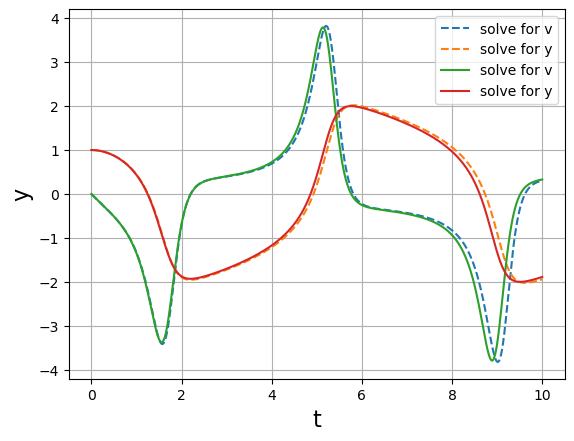

In [17]:
y0 = np.array([1.0, 0.0])
max_time = 10.0
damping = 1.0
num_time_steps = 1000
epsilon = 1.0e-6
my_oscillator = VanDerPolOscillator(damping, max_time, num_time_steps, epsilon)

# This is a useful check for comparison!
my_oscillator.integrate_using_solve_ivp(y0)
linestyle = '--'
my_oscillator.plot_solution(linestyle)

# Solve using the backward Euler method
my_oscillator.integrate_using_backward_Euler(y0)
#my_oscillator.plot_phase_plot()
linestyle = '-'
my_oscillator.plot_solution(linestyle)
plt.grid()

### ACTIVITY 2:
    
Solve Ax=b without inverting!

In the lecture we discussed how to invert a matrix without using the python linalg.inv function by iterating from an initial guess. 

Here you should implement an algorithm to invert the matrix we saw in the lecture:

$
\begin{bmatrix}
1.1 & 0.2 \\
-0.3 &  1.9
\end{bmatrix} 
\begin{bmatrix}
x \\
y
\end{bmatrix} = \begin{bmatrix}
1 \\
2
\end{bmatrix}
$

You can start with an initial guess $ x_0 = \begin{bmatrix}
0 \\
1
\end{bmatrix}
$

You can implement this using functional methods or using classes, but your solutions should:

1. Display the outputs at every iteration
2. Plot the decrease in the change between each iteration (using a matrix norm like linalg.norm())
3. Calculate and output the spectral radius of the residual matrix $R$, and check it meets the necessary condition for convergence
4. Stop once a certain level of accuracy is obtained - how many iterations are required to get an accuracy of $10^{-6}$? How strongly does this depend on the initial guess?

The spectral radius of R is  0.15811388300841897
1 [[1 1]]
2 [[0.7 1.2]]
3 [[0.69  1.165]]
4 [[0.698   1.16175]]
5 [[0.69785   1.1627875]]
6 [[0.6976575  1.16281688]]
7 [[0.69767088 1.16278947]]
8 [[0.69767502 1.1627901 ]]


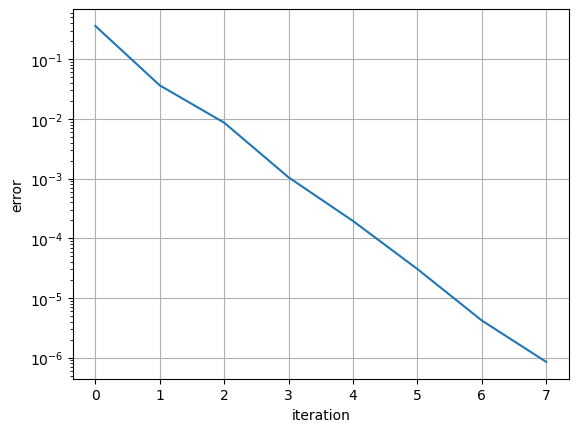

In [18]:
def calculate_spectral_radius(a_R_matrix) :
    eigenvalues = np.linalg.eigvals(a_R_matrix)
    abs_eigenvalues = abs(eigenvalues)
    spectral_radius = np.max(abs_eigenvalues)
    return spectral_radius

A0_inverse = np.matrix("1 0 ; 0 0.5")
Delta_A = np.matrix("0.1 0.2 ; -0.3 -0.1") 
b = np.matrix("1; 2")
R = - np.dot(A0_inverse, Delta_A)
c = np.dot(A0_inverse, b)
x0 = np.matrix("1 ; 1")

# First check the spectral radius of R
spectral_radius_of_R =  calculate_spectral_radius(R)
assert spectral_radius_of_R < 1.0, 'Spectral radius of R is greater than 1, method will not converge'
print("The spectral radius of R is ", spectral_radius_of_R)

# initialise the iterations
error = 1000
error_list = []
iteration = 1
x_old = np.copy(x0)
tolerance = 1e-6
while error > tolerance :
    print(iteration, x_old.transpose())
    x_new = R * x_old + c
    iteration += 1
    error = np.linalg.norm(x_new - x_old)
    x_old = x_new
    error_list.append(error)
    
plt.semilogy(error_list)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("error");

*OPTIONAL*: Implement a similar inversion process as another method in the VanDerPol class above and use it instead of the linalg function. The tricky part will be in deciding the initial guess for the iteration, as the values in A change at each iteration of the guess, and at each timestep...
_(HINT: I would keep the linalg one intact for comparison, but add an if statement and an attribute of the class to control which inversion method is used.)_

### ACTIVITY 3
    
This activity is on checking ill conditioning in a matrix problem $Ax = b$.

Here you should implement an algorithm to check ill conditioned matrices and test it on the matrix problem we saw in the lecture:

$
\begin{bmatrix}
1 & 2 \\
2 &  3.999
\end{bmatrix} 
\begin{bmatrix}
x \\
y
\end{bmatrix} = \begin{bmatrix}
4 \\
7.999
\end{bmatrix}
$

You can implement this using functional methods or using classes, but your solutions should:

1. Have a function or method to calculate the row sum norm of a given matrix as defined in the lecture
2. Have a function or method to calculate the condition number $C = \|A\| \|A^{-1}\|$ of a given matrix
3. Write a test function that gives an assert error when it detects an ill conditioned matrix
4. Test explicitly the effect of one or two examples of small changes in b on the solution x, and verify that they respect the inequality 

    $\frac{\|\Delta x)\|}{\|x\|} \le  C \frac{\|\Delta b)\|}{\|b\|} $

In [19]:
# Functions to check conditioning of a general matrix A

def row_sum_norm(A_matrix):
    """Returns the row sum norm of A."""
    
    row_sums = [abs(A_matrix[k,:]).sum() for k in range(A_matrix.shape[0])] 
    
    return max(row_sums)

def condition_number(A_matrix):
    """Returns the condition number of A""" 
    
    C = row_sum_norm(A_matrix)*row_sum_norm(np.linalg.inv(A_matrix))
    
    return C 

def check_well_conditioned(A_matrix): 
    condition_num_C_of_A = condition_number(A_matrix)
    if condition_num_C_of_A < 10**(A.shape[0]) :
        is_well_conditioned = True
    else :
        is_well_conditioned = False
        
    well_or_ill = "well" if is_well_conditioned else "ill" 
    
    print("Matrix A is " + well_or_ill + "-conditioned: C = %e" % condition_num_C_of_A)

    assert is_well_conditioned, 'Stop! The matrix is not well conditioned!'

# Apply to our problem

A = np.matrix("1 2 ; 2 3.999")
b = np.matrix("4 ; 7.999")
Delta_b = np.matrix("0.001 ; -0.001") # a small perturbation 

solution_unperturbed = np.linalg.solve(A, b)
solution_perturbed = np.linalg.solve(A, b + Delta_b)
print("Original solution:\n", solution_unperturbed)
print("Perturbed solution:\n", solution_perturbed)

# This should return the assert error if uncommented!
#check_well_conditioned(A)

C_of_A = condition_number(A)

print("The condition number of A is C = ", str(C_of_A), "which should be greater than...")

Delta_x = solution_unperturbed - solution_perturbed

compare_to_C = (row_sum_norm(Delta_x) / row_sum_norm(solution_unperturbed) 
            * row_sum_norm(b) / row_sum_norm(Delta_b))

print(compare_to_C)

Original solution:
 [[2.]
 [1.]]
Perturbed solution:
 [[-3.999]
 [ 4.   ]]
The condition number of A is C =  35988.00100000397 which should be greater than...
23993.00050002131


*OPTIONAL*: If you want another classic example of an ill conditioned problem that is not a matrix equation (although it can be related to finding the determinant of a matrix, you can look at Wilkinson's polynomial: https://en.wikipedia.org/wiki/Wilkinson%27s_polynomial.
You can even try to implement it and verify how small changes in the coefficients result in massive changes to the roots (try plotting one of the roots versus the size of the perturbation). In python you can create a polynomial by first importing the library `from numpy.polynomial import Polynomial` and then using `p = Poly.fromroots(roots)` and `p.roots()` to obtain the roots.

### ACTIVITY 4

Try to solve the ill posed problem given in the lecture using any of the methods we have learned so far for solving ODEs as initial value problems.

$\frac{dy}{dt} = y^2 t \quad y(t_0) = \alpha > 0$

Start with $\alpha = 2$ and $t_0 = 1$.

Show that the solution breaks down at $t = \sqrt{\frac{2}{\alpha} + t_0^2}$

Confirm that before that it matches the analytic solution $y(t) = \frac{2\alpha}{2+\alpha(t_0^2 - t^2)}$

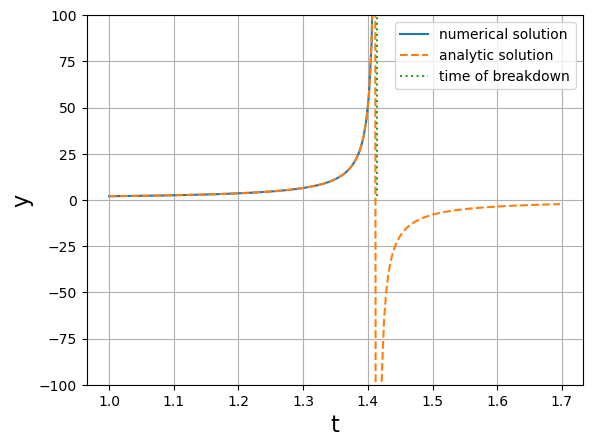

In [20]:
# Try to solve an ill posed ODE

def calculate_ill_posed_dydt(t, y) :
    """Returns the gradient dy/dt for an ill posed equation"""
    
    dydt = y*y*t
        
    return dydt

alpha = 2.0 # initial condition
t_0 = 1.0 # initial time
y_0 = np.array([alpha])
max_time = np.sqrt(2.0/alpha + t_0**2.0)
N_time_steps = 100
delta_t = max_time / N_time_steps
solution_t = np.linspace(t_0, max_time, N_time_steps+1)

solution = solve_ivp(calculate_ill_posed_dydt, [t_0,max_time],
                        y_0, t_eval=solution_t)

solution_t_analytic = np.linspace(t_0, 1.2*max_time, 2*N_time_steps+1)
analytic_solution = 2.0 * alpha / (2.0 + alpha * (t_0**2 - solution_t_analytic * solution_t_analytic))

plt.grid()
plt.xlabel("t", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.ylim(-100,100)
plt.plot(solution.t, solution.y[0], "-", label="numerical solution")
plt.plot(solution_t_analytic, analytic_solution, "--", label="analytic solution")
plt.plot(max_time * np.ones_like(solution.t), solution.y[0], ':', label="time of breakdown" )
plt.legend();